# Importing necessary libraries and setting appropriate parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet

target_shape = (100, 100)

In [2]:
TRAIN_DATASET = "Training"
TEST_DATASET = "Validation"

IMAGE_SIZE = (100,100)

BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE * 2

AUTO = tf.data.AUTOTUNE

LEARNING_RATE = 0.0001
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 10
EPOCHS = 10

OUTPUT_PATH = "output"
MODEL_PATH = os.path.join(OUTPUT_PATH, "siamese_network")
OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_PATH, "output_image.png")

# Triplet Loss Database Generator

In [3]:
class MapFunction():
	def __init__(self, imageSize):
		# define the image width and height
		self.imageSize = imageSize
	def decode_and_resize(self, imagePath):
		image = tf.io.read_file(imagePath)
		image = tf.image.decode_jpeg(image, channels=3)
		image = tf.image.convert_image_dtype(image, dtype=tf.float32)
		image = tf.image.resize(image, self.imageSize)
		return image
	def __call__(self, anchor, positive, negative):
		anchor = self.decode_and_resize(anchor)
		positive = self.decode_and_resize(positive)
		negative = self.decode_and_resize(negative)
		return (anchor, positive, negative)

In [6]:
class TripletGenerator:
    def __init__(self, datasetPath):
        self.fruitNames = list()
        for folderName in os.listdir(datasetPath):
            absoluteFolderName = os.path.join(datasetPath, folderName)
            numImages = len(os.listdir(absoluteFolderName))
            if numImages > 1:
                self.fruitNames.append(absoluteFolderName)
        self.allFruit = self.generate_all_fruit_dict()
    def generate_all_fruit_dict(self):
        allFruit = dict()
        for fruitName in self.fruitNames:
            imageNames = os.listdir(fruitName)
            fruitPhotos = [
                os.path.join(fruitName, imageName) for imageName in imageNames
                if os.path.isfile(os.path.join(fruitName, imageName))
            ]
            allFruit[fruitName] = fruitPhotos
        return allFruit
    def get_next_element(self):
        while True:
            anchorName = random.choice(self.fruitNames)
            temporaryNames = self.fruitNames.copy()
            temporaryNames.remove(anchorName)
            negativeName = random.choice(temporaryNames)
            (anchorPhoto, positivePhoto) = np.random.choice(
                a = self.allFruit[anchorName],
                size=2,
                replace=False
            )
            negativePhoto = random.choice(self.allFruit[negativeName])
            yield (anchorPhoto, positivePhoto, negativePhoto)
    def get_next_element_example(self):
        i=0
        while i<10:
            i+=1
            anchorName = random.choice(self.fruitNames)
            temporaryNames = self.fruitNames.copy()
            temporaryNames.remove(anchorName)
            negativeName = random.choice(temporaryNames)
            (anchorPhoto, positivePhoto) = np.random.choice(
                a = self.allFruit[anchorName],
                size=2,
                replace=False
            )
            negativePhoto = random.choice(self.allFruit[negativeName])
            yield (anchorPhoto, positivePhoto, negativePhoto)

# Displaying Example Images

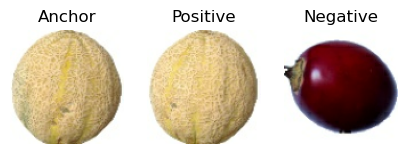

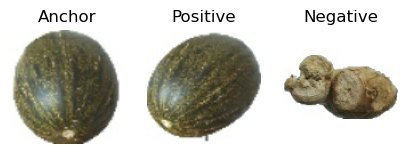

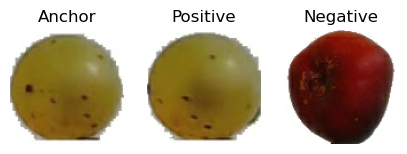

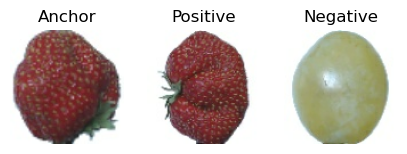

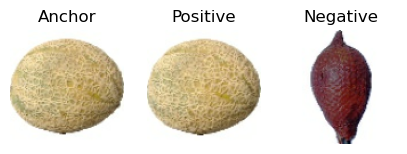

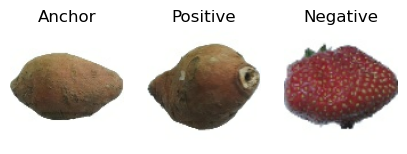

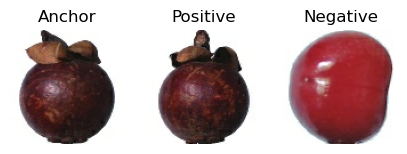

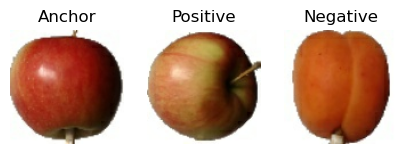

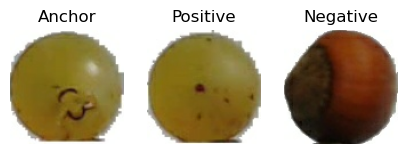

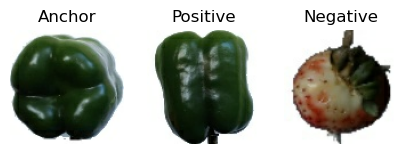

In [7]:
image_processor = MapFunction(IMAGE_SIZE)

# Create an instance of TripletGenerator
dataset_path = "Training"
triplet_generator = TripletGenerator(dataset_path)

# Iterate through the generated triplets
for anchor_path, positive_path, negative_path in triplet_generator.get_next_element_example():
    # Process images using MapFunction
    anchor_image, positive_image, negative_image = image_processor(anchor_path, positive_path, negative_path)
    
    # Display the images
    fig, axes = plt.subplots(1, 3, figsize=(5, 5))
    axes[0].imshow(anchor_image)
    axes[0].set_title('Anchor')
    axes[0].axis('off')
    axes[1].imshow(positive_image)
    axes[1].set_title('Positive')
    axes[1].axis('off')
    axes[2].imshow(negative_image)
    axes[2].set_title('Negative')
    axes[2].axis('off')
    plt.show()

# Creating a Siamese Network-based model using Triplet Loss

### Implementing the embedding generator

In [8]:
# generating the image embeddings

# transfer model
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

# our added layers
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

# make the tranferred model layers untrainable - freeze the layers to learn only our layers
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

### Calculating the distances between image embeddings

In [9]:
# class that calculates the distances between embeddings between anchor-positive and anchor-negative
class DistanceLayer(layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = self.square_distance(anchor, positive)
        an_distance = self.square_distance(anchor, negative)
        return (ap_distance, an_distance)

    def square_distance(self, x, y):
        return tf.reduce_sum(tf.square(x - y), axis=-1)


anchor_input = layers.Input(name = "anchor", shape = target_shape + (3,))
positive_input = layers.Input(name = "positive", shape = target_shape + (3,))
negative_input = layers.Input(name = "negative", shape = target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs = [anchor_input, positive_input, negative_input], outputs = distances
)

### Creating the Siamese-Network model that uses the Triplet Loss function

In [10]:
class SiameseModel(Model):
    """The Siamese Network model with custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

#### Model summary

In [11]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

In [12]:
siamese_model.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    40,565,632 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,565,632 (154.75 MB)

 Trainable params: 25,907,712 (98.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

### Generating the train and validation datasets

In [13]:
train_dataset = tf.data.Dataset.from_generator(
    TripletGenerator(TRAIN_DATASET).get_next_element,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    TripletGenerator(TEST_DATASET).get_next_element,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
)


map_fn = MapFunction(IMAGE_SIZE)
train_dataset = train_dataset.map(map_fn)
validation_dataset = validation_dataset.map(map_fn)

train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)

# Training the model

In [107]:
history = siamese_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS
)

Epoch 1/10


2024-03-28 11:49:58.449187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:88: Filling up shuffle buffer (this may take a while): 169 of 512
2024-03-28 11:50:08.794134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:88: Filling up shuffle buffer (this may take a while): 312 of 512
2024-03-28 11:50:28.725311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:88: Filling up shuffle buffer (this may take a while): 476 of 512
2024-03-28 11:50:36.788059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 675s 12s/step - loss: 0.1874 - val_loss: 0.1205
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 592s 12s/step - loss: 0.0605 - val_loss: 0.1535
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 626s 13s/step - loss: 0.0511 - val_loss: 0.1409
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 606s 12s/step - loss: 0.0435 - val_loss: 0.0924
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 611s 12s/step - loss: 0.0416 - val_loss: 0.0708
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 632s 13s/step - loss: 0.0355 - val_loss: 0.0801
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 632s 13s/step - loss: 0.0335 - val_loss: 0.1156
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 642s 13s/step - loss: 0.0328 - val_loss: 0.1061
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 641s 13s/step - loss: 0.0300 - val_loss: 0.1151
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 636s 13s/step - loss: 0.0249 - val_loss: 0.1583
